# Create pixel-level snow dynamics results from IMS Snow Cubes

In [27]:
import numpy as np
import hvplot.xarray
import xarray as xr

import sys
sys.path.append('C:/Users/mbonney/OneDrive - NRCan RNCan/Projects/UtilityCode/DataAccess/Utilities')
import PreProcess_Utils as pputil

sys.path.append('C:/Users/mbonney/OneDrive - NRCan RNCan/Projects/UtilityCode/Modelling/Utilities')
import Snow_Utils as snow_util

In [1]:
from dask.distributed import LocalCluster

cluster = LocalCluster(n_workers = 10, threads_per_worker = 10, memory_limit = 0) # Refined through testing
client = cluster.get_client()
client # Can open in other window by clicking 'Dashboard' link below

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 100,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61013,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 100
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:61078,Total threads: 10
Dashboard: http://127.0.0.1:61092/status,Memory: 0 B
Nanny: tcp://127.0.0.1:61016,


2024-10-29 17:11:22,410 - distributed.nanny - WARNING - Restarting worker
2024-10-29 17:11:22,433 - distributed.nanny - WARNING - Restarting worker
2024-10-29 17:11:22,445 - distributed.nanny - WARNING - Restarting worker
2024-10-29 17:11:22,456 - distributed.nanny - WARNING - Restarting worker
2024-10-29 17:11:22,465 - distributed.nanny - WARNING - Restarting worker
2024-10-29 17:11:22,474 - distributed.nanny - WARNING - Restarting worker
2024-10-29 17:11:22,484 - distributed.nanny - WARNING - Restarting worker
2024-10-29 17:11:22,493 - distributed.nanny - WARNING - Restarting worker
2024-10-29 17:11:22,498 - distributed.nanny - WARNING - Restarting worker
2024-10-29 17:11:22,517 - distributed.nanny - WARNING - Restarting worker


# Load Winter Year Snow Cube

In [122]:
path = r'C:\Users\mbonney\OneDrive - NRCan RNCan\Projects\Alaska\2 IMS\ims_nc\IMS_snowCube_winterYear'
winterYear = '2223'

In [123]:
%%time
snowCube = pputil.uploadNC(path + winterYear + '.nc', type = 'dataarray', chunks = {'time': 100, 'band': -1, 'x': -1, 'y': -1})
snowCube

CPU times: total: 15.6 ms
Wall time: 29.7 ms


<xarray.DataArray (time: 365, y: 73, x: 47)> Size: 1MB
dask.array<open_dataset-__xarray_dataarray_variable__, shape=(365, 73, 47), dtype=uint8, chunksize=(100, 73, 47), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 376B 4.002e+05 4.012e+05 ... 4.452e+05 4.462e+05
  * y            (y) float64 584B 7.679e+06 7.678e+06 ... 7.608e+06 7.607e+06
  * time         (time) datetime64[ns] 3kB 2022-07-24 2022-07-25 ... 2023-07-23
    variable     <U18 72B ...
    spatial_ref  int64 8B ...

# Create Snow Dynamics

In [124]:
%%time
snowCube = snow_util.cleanSnowCube(snowCube, type = 'binary', temporal = 'continuous', thresh = 7, verbose = True)  
snowDynamics = snow_util.dailySnowCube2SnowDynamics(snowCube, uncertainty = False, verbose = True) # Annual snow dynamics
snowDynamics = pputil.loadXR(snowDynamics)
snowDynamics

Calculated rolling median through time of length 13.
Calculated cumulative sum that resets when non-snow is found.
Identified periods when 7+ consecutive snow observations occured (skipping NaN).
Created flipped snowCube to identify non-snow periods.
Calculated cumulative sum that resets when snow is found.
Identified periods when 7+ consecutive non-snow observations occured (skipping NaN).
Removed (NaN) snow and non-snow periods below 7 consecutive observations.
Filled in NaN transition days with nearest neighbor.
Created empty snowDynamics Dataset to fill.
Calculated cumulative sum of binary snowCube (used in multiple products).
Added snow cover start date (# days from Dec 31) to snowDynamics.
Added snow cover end date (# days from Dec 31) to snowDynamics.
Added snow cover length (# days with snow cover) to snowDynamics.
Added snow period count (# seperated snow periods) to snowDynamics.
Added snow status (0 = Regular fall/melt, 1 = Perennial, 2 = Inconsistent perennial, 3 = Snow fre

<xarray.Dataset> Size: 42kB
Dimensions:       (x: 47, y: 73)
Coordinates:
  * x             (x) float64 376B 4.002e+05 4.012e+05 ... 4.452e+05 4.462e+05
  * y             (y) float64 584B 7.679e+06 7.678e+06 ... 7.608e+06 7.607e+06
    spatial_ref   int64 8B 0
    variable      <U18 72B 'IMS_Surface_Values'
Data variables:
    snow_start    (y, x) float32 14kB -95.0 -95.0 -95.0 ... -103.0 -103.0 -96.0
    snow_end      (y, x) float32 14kB 154.0 154.0 154.0 ... 171.0 171.0 162.0
    snow_length   (y, x) uint16 7kB 250 250 250 250 250 ... 259 260 275 275 259
    snow_periods  (y, x) uint8 3kB 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    snow_status   (y, x) uint8 3kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

# Save

In [125]:
%%time
snowDynamics['snow_start'].rio.to_raster('IMS_snow_start_winterYear' + winterYear + '.tif')
snowDynamics['snow_end'].rio.to_raster('IMS_snow_end_winterYear' + winterYear + '.tif')
snowDynamics['snow_length'].rio.to_raster('IMS_snow_length_winterYear' + winterYear + '.tif')
snowDynamics['snow_periods'].rio.to_raster('IMS_snow_periods_winterYear' + winterYear + '.tif')
snowDynamics['snow_status'].rio.to_raster('IMS_snow_status_winterYear' + winterYear + '.tif')

CPU times: total: 62.5 ms
Wall time: 196 ms


# Map

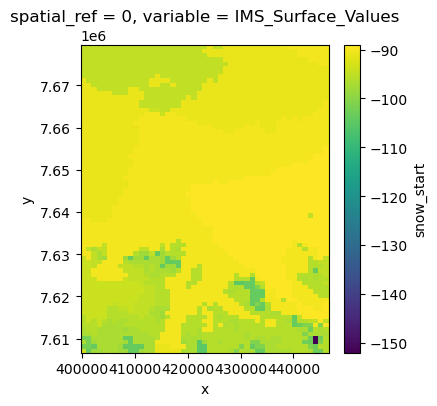

In [126]:
snowDynamics['snow_start'].plot(size = 4, aspect = 'equal')

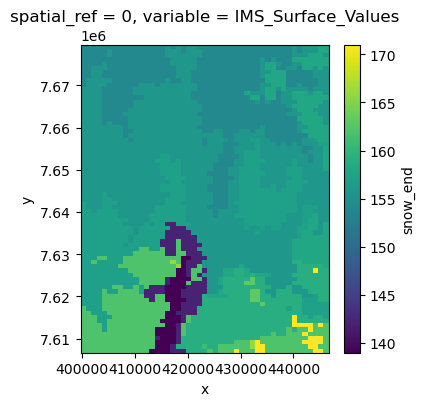

In [127]:
snowDynamics['snow_end'].plot(size = 4, aspect = 'equal')

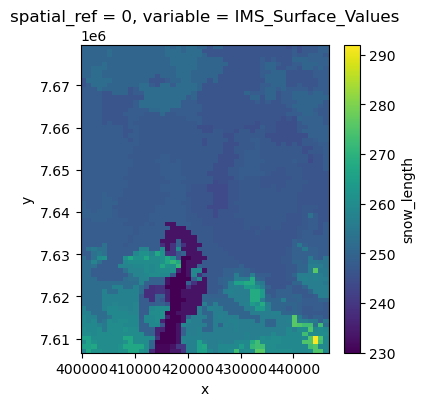

In [128]:
snowDynamics['snow_length'].plot(size = 4, aspect = 'equal')

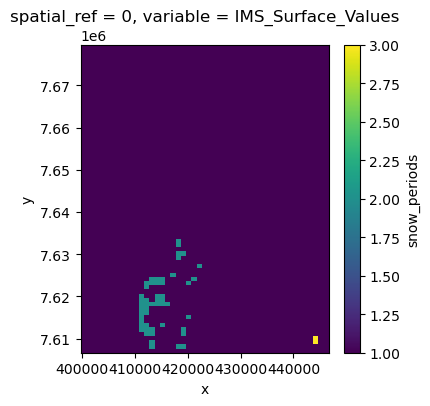

In [129]:
snowDynamics['snow_periods'].plot(size = 4, aspect = 'equal')

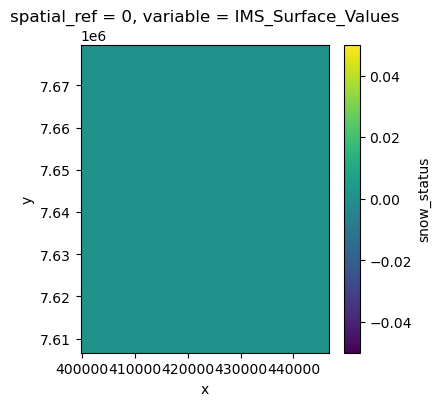

In [130]:
snowDynamics['snow_status'].plot(size = 4, aspect = 'equal')

# Pixel Time-series

In [131]:
x = np.random.randint(0, snowCube.shape[1])
print(x)
y = np.random.randint(0, snowCube.shape[2])
print(y)

print(snowCube[:, x, y]['x'].values) #.rio.set_spatial_dims('x', 'y').rio.reproject('EPSG:4326')
print(snowCube[:, x, y]['y'].values)

snowCube[:, x, y].rename('snowCube').hvplot(height = 600, width = 1000)

71
1
401169.6275456902
7608155.112374026


:Curve   [time]   (snowCube)